# stacking_fault_map_2D Calculation

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Chandler A. Becker**, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), *Office of Data and Informatics, NIST*.

**Zachary T. Trautt**, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), *Materials Measurement Science Division, NIST*.

Version: 2018-06-24

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## Introduction

The __stacking_fault_map_2D__ calculation evaluates the full 2D generalized stacking fault map for an array of shifts along a specified crystallographic plane.  A regular grid of points is established and the generalized stacking fault energy is evaluated at each.

__Version notes__: This was previously called the stacking_fault_multi calculation and was renamed for clarity.

__Disclaimer #1__: The system's dimension perpendicular to the fault plane should be large to minimize the interaction of the free surface and the stacking fault.

## Method and Theory

First, an initial system is generated.  This is accomplished by

1. Starting with a unit cell system.

2. Generating a transformed system by rotating the unit cell such that the new system's box vectors correspond to crystallographic directions, and filled in with atoms to remain a perfect bulk cell when the three boundaries are periodic.

3. All atoms are shifted by a fractional amount of the box vectors if needed.

4. A supercell system is constructed by combining multiple replicas of the transformed system.

The system is then cut by making one of the box boundaries non-periodic.  A limitation placed on the calculation is that the normal to the cut plane must correspond to one of the three Cartesian ($x$, $y$, or $z$) axes.  If true, then of the system's three box vectors ($\vec{a}$, $\vec{b}$, and $\vec{c}$), two will be parallel to the plane, and the third will not.  The non-parallel box vector is called the cutboxvector, and for LAMMPS compatible systems, the following conditions can be used to check the system's compatibility:

- cutboxvector = 'c': all systems allowed.

- cutboxvector = 'b': the system's yz tilt must be zero.

- cutboxvector = 'a': the system's xy and xz tilts must be zero.

A LAMMPS simulation performs an energy/force minimization on the system where the atoms are confined to only relax along the Cartesian direction normal to the cut plane. 

A mathematical fault plane parallel to the cut plane is defined in the middle of the system.  A generalized stacking fault system can then be created by shifting all atoms on one side of the fault plane by a vector, $\vec{s}$.  The shifted system is then relaxed using the same confined energy/force minimization used on the non-shifted system.  The generalized stacking fault energy, $\gamma_{gsf}$, can then be computed by comparing the total energy of the system, $E^{total}$, before and after $\vec{s}$ is applied

$$ \gamma_{gsf}(\vec{s}) = \frac{E^{total}(\vec{s}) - E^{total}(\vec{0})}{A_{fault}},$$

where $A_{fault}$ is the area of the fault plane, which can be computed using the two box vectors, $\vec{a_1}$ and $\vec{a_2}$, that are not the cutboxvector.

$$A_{fault} = \left| \vec{a_1} \times \vec{a_2} \right|,$$

Additionally, the relaxation normal to the glide plane is characterized using the center of mass of the atoms above and below the cut plane.  Notably, the component of the center of mass normal to the glide/cut plane is calculated for the two halves of the the system, and the difference is computed

$$ delta_{gsf} = \left<x\right>^{above} - \left<x\right>^{below}.$$

The relaxation normal is then taken as the change in the center of mass difference after the shift is applied.

$$ \Delta\delta_{gsf} = delta_{gsf}(\vec{s}) - delta_{gsf}(\vec{0}).$$

The stacking_fault_multi calculation evaluates both $\gamma_{gsf}$ and $\Delta\delta_{gsf}$ for a complete 2D grid of $\vec{s}$ values.  The grid is built by taking fractional steps along two vectors parallel to the shift plane.

## Demonstration

### 1. Library imports

Import libraries needed by the calculation. The external libraries used are:

- [numpy](http://www.numpy.org/)

- [pandas](https://pandas.pydata.org/)

- [DataModelDict](https://github.com/usnistgov/DataModelDict)

- [atomman](https://github.com/usnistgov/atomman)

- [iprPy](https://github.com/usnistgov/iprPy)

In [1]:
# Standard library imports
from __future__ import division, absolute_import, print_function
import os
import sys
import uuid
import shutil
import datetime
from copy import deepcopy

# http://www.numpy.org/
import numpy as np 

# https://pandas.pydata.org/
import pandas as pd

# https://github.com/usnistgov/DataModelDict 
from DataModelDict import DataModelDict as DM

# https://github.com/usnistgov/atomman 
import atomman as am
import atomman.lammps as lmp
import atomman.unitconvert as uc

# https://github.com/usnistgov/iprPy
import iprPy

print('Notebook last executed on', datetime.date.today(), 'using iprPy version', iprPy.__version__)

Notebook last executed on 2018-09-24 using iprPy version 0.8.2


Import plotting library for the Notebook

- [matplotlib](https://matplotlib.org/)

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

#### 1.2. Default calculation setup

In [3]:
# Specify calculation style
calc_style = 'stacking_fault_map_2D'

# If workingdir is already set, then do nothing (already in correct folder)
try:
    workingdir = workingdir

# Change to workingdir if not already there
except:
    workingdir = os.path.join(os.getcwd(), 'calculationfiles', calc_style)
    if not os.path.isdir(workingdir):
        os.mkdir(workingdir)
    os.chdir(workingdir)

# Default iprPy library directory
librarydir = os.path.join(iprPy.rootdir, '..', 'library')

### 2. Assign values for the calculation's run parameters

#### 2.1 Specify system-specific paths

- __lammps_command__ is the LAMMPS command to use.

- __mpi_command__ MPI command for running LAMMPS in parallel. A value of None will run simulations serially.

In [4]:
lammps_command = 'lmp_serial'
mpi_command = None

#### 2.2. Load interatomic potential

- __potential_name__ gives the name of the potential_LAMMPS reference record in the iprPy library to use for the calculation.  

- __potential_file__ gives the path to the potential_LAMMPS reference record to use.  Here, this parameter is automatically generated using potential_name and librarydir.

- __potential_dir__ gives the path for the folder containing the artifacts associated with the potential (i.e. eam.alloy file).  Here, this parameter is automatically generated using potential_name and librarydir.

- __potential__ is an atomman.lammps.Potential object (required).  Here, this parameter is automatically generated from potential_file and potential_dir.

In [5]:
potential_name = '1999--Mishin-Y--Ni--LAMMPS--ipr1'

# Define potential_file and potential_dir using librarydir and potential_name
potential_file = os.path.join(librarydir, 'potential_LAMMPS', potential_name) + '.json'
potential_dir = os.path.join(librarydir, 'potential_LAMMPS', potential_name)

# Initialize Potential object using potential_file and potential_dir.
potential = lmp.Potential(potential_file, potential_dir)
print('Successfully loaded potential', potential)

Successfully loaded potential 1999--Mishin-Y--Ni--LAMMPS--ipr1


#### 2.3. Load initial unit cell system

- __prototype_name__ gives the name of the crystal_prototype reference record in the iprPy library to load. 

- __symbols__ is a list of the potential's elemental model symbols to associate with the unique atom types of the loaded system. 

- __box_parameters__ is a list of the a, b, c lattice constants to assign to the loaded file.

- __load_file__ gives the path to the atomic configuration file to load for the ucell system.  Here, this is generated automatically using prototype_name and librarydir.

- __load_style__ specifies the format of load_file.  Here, this is automatically set for crystal_prototype records.

- __load_options__ specifies any other keyword options for properly loading the load_file.  Here, this is automatically set for crystal_prototype records.

- __ucell__ is an atomman.System representing a fundamental unit cell of the system (required).  Here, this is generated using the load_* parameters and symbols.

In [6]:
prototype_name = 'A1--Cu--fcc'
symbols = ['Ni']
box_parameters = uc.set_in_units([3.52, 3.52, 3.52], 'angstrom')

# Define load_file using librarydir and prototype_name
load_file = os.path.join(librarydir, 'crystal_prototype', prototype_name+'.json')

# Define load_style and load_options for crystal_prototype records
load_style = 'system_model'
load_options = {}

# Create ucell by loading prototype record
ucell = am.load(load_style, load_file, symbols=symbols, **load_options)

# Rescale ucell using box_parameters
ucell.box_set(a=box_parameters[0], b=box_parameters[1], c=box_parameters[2], scale=True)

print(ucell)

avect =  [ 3.520,  0.000,  0.000]
bvect =  [ 0.000,  3.520,  0.000]
cvect =  [ 0.000,  0.000,  3.520]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Ni',)
pbc = [ True  True  True]
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   1.760 |   1.760
      2 |       1 |   1.760 |   0.000 |   1.760
      3 |       1 |   1.760 |   1.760 |   0.000


#### 2.4. Specify the defect parameters

- __stackingfault_name__ gives the name of the stacking_fault reference record in the iprPy library to use. 

- __numshifts1__ is the number of shifts along shiftvector1 to evaluate. 

- __numshifts2__ is the number of shifts along shiftvector2 to evaluate. 

- __stackingfault_file__ gives the path to the stacking_fault reference record to use. Here, this is built automatically using stackingfault_name and librarydir.

- __cutboxvector__ specifies which of the three box vectors ('a', 'b', or 'c') is to be made non-periodic to create the free surface.  Here, this is extracted from the defect model.

- __faultpos__ specifies the relative position within the rotated cell before applying sizemults where the fault plane is placed.  Here, this is extracted from the defect model.

- __shiftvector1, shiftvector2__ specify two non-parallel Miller crystal vectors within the fault plane corresponding to full planar shifts from one perfect crystal configuration to another.  Here, these are extracted from the defect model.

In [7]:
stackingfault_name = 'A1--Cu--fcc--111sf'

numshifts1 = 21
numshifts2 = 21

# Define surface_file using librarydir and surface_name
stackingfault_file = os.path.join(librarydir, 'stacking_fault', stackingfault_name+'.json')

# Parse freesurface_file using iprPy.input.interpret()
defectinputs = {'stackingfault_file':stackingfault_file}
iprPy.input.interpret('stackingfaultpart1', defectinputs)

# Extract parameters from defect model
cutboxvector = defectinputs['stackingfault_cutboxvector']
faultpos = defectinputs['stackingfault_faultpos']
shiftvector1 = defectinputs['stackingfault_shiftvector1']
shiftvector2 = defectinputs['stackingfault_shiftvector2']
print('cutboxvector =', cutboxvector)
print('faultpos =', faultpos)
print('shiftvector1 =', shiftvector1)
print('shiftvector2 =', shiftvector2)

cutboxvector = c
faultpos = 0.5
shiftvector1 =  0.5 -0.5  0.0
shiftvector2 =  0.5  0.5 -1.0


#### 2.5. Modify system

- __a_uvw__ Miller crystal vector used to generate a rotated system from ucell.  The a box vector of the rotated system will correspond to the crystal vector relative to ucell.  Here, this is extracted from the defect model.

- __b_uvw__ Miller crystal vector used to generate a rotated system from ucell.  The a box vector of the rotated system will correspond to the crystal vector relative to ucell.  Here, this is extracted from the defect model.

- __c_uvw__ Miller crystal vector used to generate a rotated system from ucell.  The a box vector of the rotated system will correspond to the crystal vector relative to ucell.  Here, this is extracted from the defect model.

- __atomshift__ fractional rigid body shift to apply to the rotated system. Here, this is extracted from the defect model.

- __sizemults__ list of three integers specifying how many times the ucell vectors of $a$, $b$ and $c$ are replicated in creating system.

- __system__ is an atomman.System to use as the input system for the calculation (required). 

In [8]:
sizemults = [5, 5, 10]

# Extract parameters from defect model
a_uvw = np.array(defectinputs['a_uvw'].strip().split(), dtype=float)
b_uvw = np.array(defectinputs['b_uvw'].strip().split(), dtype=float)
c_uvw = np.array(defectinputs['c_uvw'].strip().split(), dtype=float)
atomshift = np.array(defectinputs['atomshift'].strip().split(), dtype=float)
print('a_uvw =', a_uvw)
print('b_uvw =', b_uvw)
print('c_uvw =', c_uvw)
print('atomshift =', atomshift)

# Rotate to specified uvws
system, transform = ucell.rotate(np.array([a_uvw, b_uvw, c_uvw]), return_transform=True)

# Scale atomshift by rotated system's box vectors
shift = (atomshift[0] * system.box.avect +
         atomshift[1] * system.box.bvect +
         atomshift[2] * system.box.cvect)
system.atoms.pos += shift

# Generate system by supersizing ucell
system = system.supersize(*sizemults)
print('# of atoms in system =', system.natoms)

a_uvw = [ 1. -1.  0.]
b_uvw = [ 1.  1. -2.]
c_uvw = [1. 1. 1.]
atomshift = [0.01 0.01 0.01]
# of atoms in system = 6000


c:\users\lmh1\documents\python-packages\atomman\atomman\lammps\normalize.py:60: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  transformation = np.linalg.lstsq(vects, system.box.vects)[0].T


#### 2.6. Modify defect parameters based on modified system information

- __shiftvector1, shiftvector2__ are converted to Cartesian vectors and transformed relative to the rotated system.

- __faultpos__ is adjusted to be relative to the supercell system by placing the cut inside a/the center cell replica.

In [9]:
# Convert shift vectors from crystallographic to Cartesian vectors
shiftvector1 = np.array(shiftvector1.strip().split(), dtype=float)
shiftvector2 = np.array(shiftvector2.strip().split(), dtype=float)
cartshiftvector1 = ucell.box.vects.T.dot(shiftvector1)
cartshiftvector2 = ucell.box.vects.T.dot(shiftvector2)

# Transform shift vectors
cartshiftvector1 = transform.dot(cartshiftvector1)
cartshiftvector1[np.isclose(cartshiftvector1, 0.0, atol=1e-10, rtol=0.0)] = 0.0
cartshiftvector2 = transform.dot(cartshiftvector2)
cartshiftvector2[np.isclose(cartshiftvector2, 0.0, atol=1e-10, rtol=0.0)] = 0.0

# Identify number of size multiples, m, along cutboxvector
if   cutboxvector == 'a': 
    m = sizemults[0]
elif cutboxvector == 'b': 
    m = sizemults[1]
elif cutboxvector == 'c': 
    m = sizemults[2]

# For odd m, initial position of 0.5 goes to 0.5
if m % 2 == 1:
    faultpos = (faultpos + (m-1) * 0.5) / m
# For even m, initial position of 0.0 goes to 0.5
else:
    faultpos = (2 * faultpos + m) / (2 * m)
    
print('faultpos =', faultpos)
print('cartshiftvector1 =', cartshiftvector1)
print('cartshiftvector2 =', cartshiftvector2)

faultpos = 0.55
cartshiftvector1 = [2.48901587 0.         0.        ]
cartshiftvector2 = [0.         4.31110195 0.        ]


#### 2.6. Specify calculation-specific run parameters

- __energytolerance__ is the energy tolerance to use during the minimizations. This is unitless.

- __forcetolerance__ is the force tolerance to use during the minimizations. This is in energy/length units.

- __maxiterations__ is the maximum number of minimization iterations to use.

- __maxevaluations__ is the maximum number of minimization evaluations to use.

- __maxatommotion__ is the largest distance that an atom is allowed to move during a minimization iteration. This is in length units.

In [10]:
energytolerance = 1e-8
forcetolerance = uc.set_in_units(0.0, 'eV/angstrom')
maxiterations = 10000
maxevaluations = 100000
maxatommotion = uc.set_in_units(0.01, 'angstrom')

### 3. Define calculation function(s) and generate template LAMMPS script(s)

#### 3.1. sfmin.template

In [11]:
with open('sfmin.template', 'w') as f:
    f.write("""#LAMMPS input script that performs an energy minimization
#for a system with a stacking fault

<atomman_system_info>

<atomman_pair_info>

<fix_cut_setforce>

thermo_style custom step lx ly lz pxx pyy pzz pe
thermo_modify format float %.13e

compute peatom all pe/atom 

min_modify dmax <dmax>

dump dumpit all custom <maxeval> <sim_directory>*.dump id type x y z c_peatom
dump_modify dumpit format <dump_modify_format>

minimize <etol> <ftol> <maxiter> <maxeval>""")

#### 3.2. stackingfaultpoint()

In [12]:
def stackingfaultpoint(lammps_command, system, potential,
                       mpi_command=None, sim_directory=None,
                       cutboxvector='c', faultpos=0.5,
                       faultshift=[0.0, 0.0, 0.0], etol=0.0, ftol=0.0,
                       maxiter=10000, maxeval=100000,
                       dmax=uc.set_in_units(0.01, 'angstrom'),
                       lammps_date=None):
    """
    Perform a stacking fault relaxation simulation for a single faultshift.
    
    Parameters
    ----------
    lammps_command :str
        Command for running LAMMPS.
    system : atomman.System
        The system to perform the calculation on.
    potential : atomman.lammps.Potential
        The LAMMPS implemented potential to use.
    mpi_command : str, optional
        The MPI command for running LAMMPS in parallel.  If not given, LAMMPS
        will run serially.
    sim_directory : str, optional
        The path to the directory to perform the simuation in.  If not
        given, will use the current working directory.
    etol : float, optional
        The energy tolerance for the structure minimization. This value is
        unitless. (Default is 0.0).
    ftol : float, optional
        The force tolerance for the structure minimization. This value is in
        units of force. (Default is 0.0).
    maxiter : int, optional
        The maximum number of minimization iterations to use (default is 
        10000).
    maxeval : int, optional
        The maximum number of minimization evaluations to use (default is 
        100000).
    dmax : float, optional
        The maximum distance in length units that any atom is allowed to relax
        in any direction during a single minimization iteration (default is
        0.01 Angstroms).
    cutboxvector : str, optional
        Indicates which of the three system box vectors, 'a', 'b', or 'c', to
        cut with a non-periodic boundary (default is 'c').
    faultpos : float, optional
        The fractional position along the cutboxvector where the stacking
        fault plane will be placed (default is 0.5).
    faultshift : list of float, optional
        The vector shift to apply to all atoms above the fault plane defined
        by faultpos (default is [0,0,0], i.e. no shift applied).
    lammps_date : datetime.date or None, optional
        The date version of the LAMMPS executable.  If None, will be identified from the lammps_command (default is None).
    
    Returns
    -------
    dict
        Dictionary of results consisting of keys:
        
        - **'logfile'** (*str*) - The filename of the LAMMPS log file.
        - **'dumpfile'** (*str*) - The filename of the LAMMPS dump file
          of the relaxed system.
        - **'system'** (*atomman.System*) - The relaxed system.
        - **'A_fault'** (*float*) - The area of the fault surface.
        - **'E_total'** (*float*) - The total potential energy of the relaxed
          system.
        - **'disp'** (*float*) - The center of mass difference between atoms
          above and below the fault plane in the cutboxvector direction.
    
    Raises
    ------
    ValueError
        For invalid cutboxvectors.
    """
    
    # Set options based on cutboxvector
    if cutboxvector == 'a':
        # Assert system is compatible with planeaxis value
        if system.box.xy != 0.0 or system.box.xz != 0.0:
            raise ValueError("box tilts xy and xz must be 0 for cutboxvector='a'")
        
        # Specify cutindex
        cutindex = 0
        
        # Identify atoms above fault
        faultpos = system.box.xlo + system.box.lx * faultpos
        abovefault = system.atoms.pos[:, cutindex] > (faultpos)
        
        # Compute fault area
        faultarea = np.linalg.norm(np.cross(system.box.bvect,
                                            system.box.cvect))
        
        # Give correct LAMMPS fix setforce command
        fix_cut_setforce = 'fix cut all setforce NULL 0 0'
    
    elif cutboxvector == 'b':
        # Assert system is compatible with planeaxis value
        if system.box.yz != 0.0:
            raise ValueError("box tilt yz must be 0 for cutboxvector='b'")
        
        # Specify cutindex
        cutindex = 1
        
        # Identify atoms above fault
        faultpos = system.box.ylo + system.box.ly * faultpos
        abovefault = system.atoms.pos[:, cutindex] > (faultpos)
        
        # Compute fault area
        faultarea = np.linalg.norm(np.cross(system.box.avect,
                                            system.box.cvect))
        
        # Give correct LAMMPS fix setforce command
        fix_cut_setforce = 'fix cut all setforce 0 NULL 0'
        
    elif cutboxvector == 'c':
        # Specify cutindex
        cutindex = 2
        
        # Identify atoms above fault
        faultpos = system.box.zlo + system.box.lz * faultpos
        abovefault = system.atoms.pos[:, cutindex] > (faultpos)
        
        # Compute fault area
        faultarea = np.linalg.norm(np.cross(system.box.avect,
                                            system.box.bvect))
        
        # Give correct LAMMPS fix setforce command
        fix_cut_setforce = 'fix cut all setforce 0 0 NULL'
        
    else: 
        raise ValueError('Invalid cutboxvector')
    
    # Assert faultshift is in cut plane
    if faultshift[cutindex] != 0.0:
        raise ValueError('faultshift must be in cut plane')
    
    # Generate stacking fault system by shifting atoms above the fault
    sfsystem = deepcopy(system)
    sfsystem.pbc = [True, True, True]
    sfsystem.pbc[cutindex] = False
    sfsystem.atoms.pos[abovefault] += faultshift
    sfsystem.wrap()
    
    if sim_directory is not None:
        # Create sim_directory if it doesn't exist
        if not os.path.isdir(sim_directory):
            os.mkdir(sim_directory)
        
        # Add '/' to end of sim_directory string if needed
        if sim_directory[-1] != '/': 
            sim_directory = sim_directory + '/'
    else:
        # Set sim_directory if is None
        sim_directory = ''
    
    # Get lammps units
    lammps_units = lmp.style.unit(potential.units)
       
    #Get lammps version date
    if lammps_date is None:
        lammps_date = lmp.checkversion(lammps_command)['date']
    
    # Define lammps variables
    lammps_variables = {}
    system_info = sfsystem.dump('atom_data',
                                f=os.path.join(sim_directory, 'system.dat'),
                                units=potential.units,
                                atom_style=potential.atom_style)
    lammps_variables['atomman_system_info'] = system_info
    lammps_variables['atomman_pair_info'] = potential.pair_info(sfsystem.symbols)
    lammps_variables['fix_cut_setforce'] = fix_cut_setforce
    lammps_variables['sim_directory'] = sim_directory
    lammps_variables['etol'] = etol
    lammps_variables['ftol'] = uc.get_in_units(ftol, lammps_units['force'])
    lammps_variables['maxiter'] = maxiter
    lammps_variables['maxeval'] = maxeval
    lammps_variables['dmax'] = uc.get_in_units(dmax, lammps_units['length'])
    
    # Set dump_modify format based on dump_modify_version
    if lammps_date < datetime.date(2016, 8, 3):
        lammps_variables['dump_modify_format'] = '"%i %i %.13e %.13e %.13e %.13e"'
    else:
        lammps_variables['dump_modify_format'] = 'float %.13e'
    
    # Write lammps input script
    template_file = 'sfmin.template'
    lammps_script = os.path.join(sim_directory, 'sfmin.in')
    with open(template_file) as f:
        template = f.read()
    with open(lammps_script, 'w') as f:
        f.write(iprPy.tools.filltemplate(template, lammps_variables,
                                         '<', '>'))
    
    # Run LAMMPS
    output = lmp.run(lammps_command, lammps_script, mpi_command,
                     logfile=os.path.join(sim_directory, 'log.lammps'))
    
    # Extract output values
    thermo = output.simulations[-1]['thermo']
    logfile = os.path.join(sim_directory, 'log.lammps')
    dumpfile = os.path.join(sim_directory, '%i.dump' % thermo.Step.values[-1])
    E_total = uc.set_in_units(thermo.PotEng.values[-1],
                              lammps_units['energy'])
    
    #Load relaxed system
    sfsystem = am.load('atom_dump', dumpfile, symbols=sfsystem.symbols)
    
    # Find center of mass difference in top/bottom planes
    disp = (sfsystem.atoms.pos[abovefault, cutindex].mean()
            - sfsystem.atoms.pos[~abovefault, cutindex].mean())
    
    # Return results
    results_dict = {}
    results_dict['logfile'] = logfile
    results_dict['dumpfile'] = dumpfile
    results_dict['system'] = sfsystem
    results_dict['A_fault'] = faultarea
    results_dict['E_total'] = E_total
    results_dict['disp'] = disp
    
    return results_dict



#### 3.3. stackingfaultworker()

In [13]:
def stackingfaultworker(lammps_command, system, potential,
                        shiftvector1, shiftvector2, shiftfraction1,
                        shiftfraction2, mpi_command=None, cutboxvector=None,
                        faultpos=0.5, etol=0.0, ftol=0.0, maxiter=10000,
                        maxeval=100000, 
                        dmax=uc.set_in_units(0.01, 'angstrom'),
                        lammps_date=None):
    """
    A wrapper function around stackingfaultpoint. Converts
    shiftfractions and shiftvectors to a faultshift, runs stackingfaultpoint,
    and adds keys 'shift1' and 'shift2' to the returned dictionary
    corresponding to the shiftfractions.
    """
    
    # Compute the faultshift
    faultshift = shiftfraction1 * shiftvector1 + shiftfraction2 * shiftvector2
    
    # Name the simulation directory based on shiftfractions
    sim_directory = 'a%.10f-b%.10f' % (shiftfraction1, shiftfraction2)
    
    # Evaluate the system at the shift
    sf = stackingfaultpoint(lammps_command, system, potential,
                            mpi_command=mpi_command,
                            cutboxvector=cutboxvector,
                            faultpos=faultpos,
                            etol=etol,
                            ftol=ftol,
                            maxiter=maxiter,
                            maxeval=maxeval,
                            dmax=dmax,
                            faultshift=faultshift,
                            sim_directory=sim_directory,
                            lammps_date=lammps_date)
    
    # Add shiftfractions to sf results
    sf['shift1'] = shiftfraction1
    sf['shift2'] = shiftfraction2
    
    return sf



#### 3.4. stackingfaultmap()

In [14]:
def stackingfaultmap(lammps_command, system, potential,
                     shiftvector1, shiftvector2, mpi_command=None,
                     numshifts1=11, numshifts2=11,
                     cutboxvector=None, faultpos=0.5,
                     etol=0.0, ftol=0.0, maxiter=10000, maxeval=100000,
                     dmax=uc.set_in_units(0.01, 'angstrom')):
    """
    Computes a generalized stacking fault map for shifts along a regular 2D
    grid.
    
    Parameters
    ----------
    lammps_command :str
        Command for running LAMMPS.
    system : atomman.System
        The system to perform the calculation on.
    potential : atomman.lammps.Potential
        The LAMMPS implemented potential to use.
    shiftvector1 : list of floats or numpy.array
        One of the generalized stacking fault shifting vectors.
    shiftvector2 : list of floats or numpy.array
        One of the generalized stacking fault shifting vectors.
    mpi_command : str, optional
        The MPI command for running LAMMPS in parallel.  If not given, LAMMPS
        will run serially.
    etol : float, optional
        The energy tolerance for the structure minimization. This value is
        unitless. (Default is 0.0).
    ftol : float, optional
        The force tolerance for the structure minimization. This value is in
        units of force. (Default is 0.0).
    maxiter : int, optional
        The maximum number of minimization iterations to use (default is 
        10000).
    maxeval : int, optional
        The maximum number of minimization evaluations to use (default is 
        100000).
    dmax : float, optional
        The maximum distance in length units that any atom is allowed to relax
        in any direction during a single minimization iteration (default is
        0.01 Angstroms).
    cutboxvector : str, optional
        Indicates which of the three system box vectors, 'a', 'b', or 'c', to
        cut with a non-periodic boundary (default is 'c').
    numshifts1 : int, optional
        The number of equally spaced shiftfractions to evaluate along
        shiftvector1.
    numshifts2 : int, optional
        The number of equally spaced shiftfractions to evaluate along
        shiftvector2.
    
    Returns
    -------
    dict
        Dictionary of results consisting of keys:
        
        - **'shift1'** (*numpy.array of float*) - The fractional shifts along
          shiftvector1 where the stacking fault was evaluated.
        - **'shift2'** (*numpy.array of float*) - The fractional shifts along
          shiftvector2 where the stacking fault was evaluated.
        - **'E_gsf'** (*numpy.array of float*) - The stacking fault formation
          energies measured for all the (shift1, shift2) coordinates.
        - **'delta_disp'** (*numpy.array of float*) - The change in the center
          of mass difference between before and after applying the faultshift
          for all the (shift1, shift2) coordinates.
        - **'A_fault'** (*float*) - The area of the fault surface.
    """
   
    # Start sf_df as empty list
    sf_df = []

    # Construct mesh of regular points
    shifts1, shifts2 = np.meshgrid(np.linspace(0, 1, numshifts1),
                                   np.linspace(0, 1, numshifts2))
    
    # Identify lammps_date version
    lammps_date = lmp.checkversion(lammps_command)['date']
    
    # Loop over all shift combinations
    for shiftfraction1, shiftfraction2 in zip(shifts1.flat, shifts2.flat):
        
        # Evaluate the system at the shift
        sf_df.append(stackingfaultworker(lammps_command, system, potential,
                                         shiftvector1, shiftvector2,
                                         shiftfraction1, shiftfraction2,
                                         mpi_command=mpi_command,
                                         cutboxvector=cutboxvector,
                                         faultpos=faultpos,
                                         etol=etol,
                                         ftol=ftol,
                                         maxiter=maxiter,
                                         maxeval=maxeval,
                                         dmax=dmax,
                                         lammps_date=lammps_date))
    
    # Convert sf_df to pandas DataFrame
    sf_df = pd.DataFrame(sf_df)
    
    # Identify the zeroshift column
    zeroshift = sf_df[(np.isclose(sf_df.shift1, 0.0, atol=1e-10, rtol=0.0)
                     & np.isclose(sf_df.shift2, 0.0, atol=1e-10, rtol=0.0))]
    assert len(zeroshift) == 1, 'zeroshift simulation not uniquely identified'
    
    # Get zeroshift values
    E_total_0 = zeroshift.E_total.values[0]
    A_fault = zeroshift.A_fault.values[0]
    disp_0 = zeroshift.disp.values[0]
    
    # Compute the stacking fault energy
    E_gsf = (sf_df.E_total.values - E_total_0) / A_fault
    
    # Compute the change in displacement normal to fault plane
    delta_disp = sf_df.disp.values - disp_0
    
    results_dict = {}
    results_dict['shift1'] = sf_df.shift1.values
    results_dict['shift2'] = sf_df.shift2.values
    results_dict['E_gsf'] = E_gsf
    results_dict['delta_disp'] = delta_disp
    results_dict['A_fault'] = A_fault
    
    return results_dict



### 4. Run calculation function(s)

In [15]:
results_dict = stackingfaultmap(lammps_command, system, potential,
                                cartshiftvector1, cartshiftvector2,
                                mpi_command = mpi_command,
                                numshifts1 = numshifts1, 
                                numshifts2 = numshifts2,
                                cutboxvector = cutboxvector,
                                faultpos = faultpos,
                                etol = energytolerance,
                                ftol = forcetolerance,
                                maxiter = maxiterations,
                                maxeval = maxevaluations,
                                dmax = maxatommotion)

In [16]:
results_dict.keys()

dict_keys(['shift1', 'shift2', 'E_gsf', 'delta_disp', 'A_fault'])

### 5. Report results

#### 5.1. Define units for outputting values

- __length_unit__ is the unit of area to display delta displacemets in.

- __area_unit__ is the unit of area to display fault area in.

- __energy_unit__ is the unit of energy to display cohesive energies in.

- __energyperarea_unit__ is the energy per area to report the surface energy in.

In [17]:
length_unit = 'nm'
area_unit = 'nm^2'
energy_unit = 'eV'
energyperarea_unit = 'mJ/m^2'

#### 5.2. Print $A_{fault}$

In [18]:
print('A_fault =', uc.get_in_units(results_dict['A_fault'], area_unit), area_unit)

A_fault = 10.730401163050708 nm^2


#### 5.3. Load results as an atomman.defect.GammaSurface object and plot data

In [19]:
gamma = am.defect.GammaSurface(a1vect=shiftvector1,
                               a2vect=shiftvector2,
                               box=ucell.box,
                               a1=results_dict['shift1'],
                               a2=results_dict['shift2'],
                               E_gsf=results_dict['E_gsf'],
                               delta=results_dict['delta_disp'])

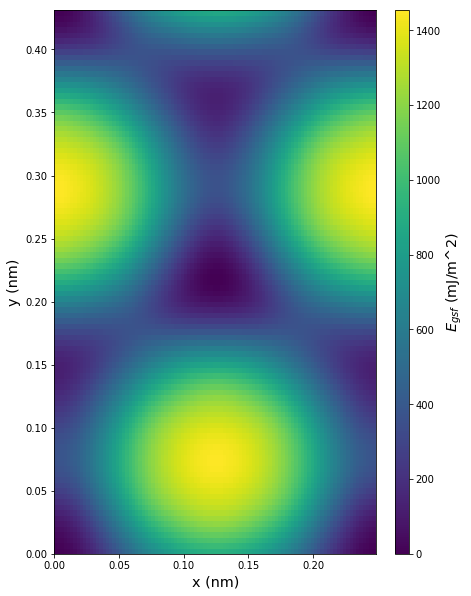

In [20]:
gamma.E_gsf_surface_plot(length_unit=length_unit, energyperarea_unit=energyperarea_unit)
plt.show()

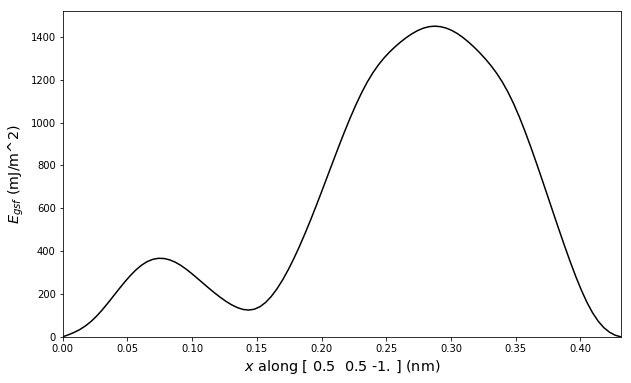

In [21]:
gamma.E_gsf_line_plot(vect=[0.5, 0.5, -1], length_unit=length_unit,
                      energyperarea_unit=energyperarea_unit)
plt.show()